In [1]:
import sys
sys.path.insert(0, "../src")

from pathlib import Path
from collections import Counter
from pprint import pprint
from itertools import product
from concurrent import futures

import pandas as pd
import numpy as np
import seaborn as sns
import spacy
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

from src.gen.util import read_gzip_data, write_gzip_data

datap_l1 = Path("/users/k21190024/study/fact-check-transfer-learning/scratch/dumps/data/level/1")
datap_l2 = Path("/users/k21190024/study/fact-check-transfer-learning/scratch/dumps/data/level/2")
dumpp = Path("/users/k21190024/study/fact-check-transfer-learning/scratch/dumps/explore/level/2")
if not dumpp.exists():
    dumpp.mkdir(parents=True)
    
nlp = spacy.blank("yo")

# General Functions

In [2]:
def unpack_fever_corpus(res):
    return [{"fever-corpus-evidence": np.concatenate(tuple(list(i.values())[0] for i in res))}]

def unpack_dfls(res):
    unlist = []
    for r in res:
        if len(r) > 1:
            if isinstance(r, dict):
                for i in r:
                    unlist.append({i: r[i]})
        else:
            unlist.append(r)
    return unlist

# Load data

In [3]:
cla = "claims_lemma.pkl.gz"
cor = "corpus_lemma.pkl.gz"

# Explore

In [4]:
fls = [
    datap_l2.joinpath("scifact", cla), datap_l2.joinpath("scifact", cor)
    , datap_l2.joinpath("fever", cla)#, datap_l2.joinpath("fever", cor)
    , datap_l2.joinpath("climatefever", cla), datap_l2.joinpath("climatefever", cor)
]

fever_cor = datap_l2.joinpath("fever", "part")
fever_n_jobs = 30

## Token per doc

In [16]:
def cf_token_per_doc():
    ls = read_gzip_data(datap_l1.joinpath("climatefever", "climatefever.json.gz"))
    claims = []
    evidences = []
    titles = []
    for doc in ls:
        claims.append(doc["claim"])
        for e in doc["evidences"]:
            evidences.append(" ".join(e["evidence"]))
            titles.append(e["article"])
            
    claims_len = [len([t for t in doc]) for doc in nlp.pipe(claims, n_process=10, batch_size=1000)]
    evidences_len = [len([t for t in doc]) for doc in nlp.pipe(evidences, n_process=10, batch_size=1000)]
    titles_len = [len([t for t in doc]) for doc in nlp.pipe(titles, n_process=10, batch_size=1000)]
    return {
        "climatefever-claims-claims": np.array(claims_len), 
        "climatefever-corpus-evidence": np.array(evidences_len),
        "climatefever-corpus-title": np.array(titles_len)
    }

def sf_token_per_doc():
    corpus = read_gzip_data(datap_l1.joinpath("scifact", "corpus.json.gz"))
    ls = read_gzip_data(datap_l1.joinpath("scifact", "fullscifact.json.gz"))
    claims = []
    evidences = []
    titles = []
    for doc in ls:
        claims.append(doc["claim"])
    for doc in corpus.values():
        titles.append(doc["title"])
        evidences.append(" ".join(doc["abstract"]))
    
    claims_len = [len([t for t in doc]) for doc in nlp.pipe(claims, n_process=10, batch_size=1000)]
    evidences_len = [len([t for t in doc]) for doc in nlp.pipe(evidences, n_process=10, batch_size=1000)]
    titles_len = [len([t for t in doc]) for doc in nlp.pipe(titles, n_process=10, batch_size=1000)]
    return {
        "scifact-claims-claims": np.array(claims_len),
        "scifact-corpus-evidence": np.array(evidences_len),
        "scifact-corpus-title": np.array(titles_len)
    }

def f_token_per_doc():
    def process_evidence(fp):
        corpus = read_gzip_data(fp)
        evidences = [doc["text"] for doc in corpus.values()]
        del corpus
        evidences_len = [len([t for t in doc]) for doc in nlp.pipe(evidences, n_process=20, batch_size=5000)]
        return np.array(evidences_len)

    ls = read_gzip_data(datap_l1.joinpath("fever", "fulltrain.json.gz"))
    claims = [d["claim"] for d in ls]
    claims_len = [len([t for t in doc]) for doc in nlp.pipe(claims, n_process=10, batch_size=1000)]
    del claims
    evidences_len = [process_evidence(fp) for fp in datap_l1.joinpath("fever", "corpus").iterdir()]
    return {
        "fever-claims-claims": np.array(claims_len),
        "fever-corpus-evidence": np.hstack(evidences_len)
    }

In [20]:
tokenp = dumpp.joinpath("tokens")
if not tokenp.exists():
    tokenp.mkdir()
    cf_tokens = cf_token_per_doc()
    sf_tokens = sf_token_per_doc()
    f_tokens = f_token_per_doc()
    write_gzip_data(tokenp.joinpath("climatefever-token-length.pkl.gz"), cf_tokens)
    write_gzip_data(tokenp.joinpath("scifact-token-length.pkl.gz"), sf_tokens)
    write_gzip_data(tokenp.joinpath("fever-token-length.pkl.gz"), f_tokens)
else:
    cf_tokens = read_gzip_data(tokenp.joinpath("climatefever-token-length.pkl.gz"))
    sf_tokens = read_gzip_data(tokenp.joinpath("scifact-token-length.pkl.gz"))
    f_tokens = read_gzip_data(tokenp.joinpath("fever-token-length.pkl.gz"))
all_tokens = {}
all_tokens.update(cf_tokens)
all_tokens.update(sf_tokens)
all_tokens.update(f_tokens)

In [21]:
df_tokens = []
for k, v in all_tokens.items():
    df_tokens.append({
        "dataset": k,
        "mean": np.mean(v),
        "median": np.median(v),
        "min": np.min(v),
        "max": np.max(v),
    })
df_tokens = pd.DataFrame(df_tokens)
df_tokens.sort_values("dataset")

,dataset,mean,median,min,max
0,climatefever-claims-claims,23.276873,22.0,4,76
1,climatefever-corpus-evidence,171.132638,158.0,13,1979
2,climatefever-corpus-title,2.705277,2.0,1,12
6,fever-claims-claims,9.510055,9.0,3,107
7,fever-corpus-evidence,99.417483,63.0,1,131236
3,scifact-claims-claims,14.472676,13.0,4,46
4,scifact-corpus-evidence,242.160718,226.0,40,1749
5,scifact-corpus-title,15.081227,14.0,1,47


## Lemma per doc

In [15]:
def lemma_per_doc(fp):
    ls = read_gzip_data(fp)
    res = {}
    for k, v in ls.items():
        if k == "ner":
            continue
        res[f"{fp.parent.name}-{fp.name.split('_')[0]}-{k}"] = np.array([len(l) for l in v])
    return res

res_ls = (
    unpack_dfls(Parallel(n_jobs=len(fls))(delayed(lemma_per_doc)(fp) for fp in fls)) 
    + unpack_fever_corpus(Parallel(n_jobs=fever_n_jobs)(delayed(lemma_per_doc)(fp) for fp in fever_cor.iterdir()))
)

def lemma_stats(res):
    doc = list(res.keys())[0]
    lemmas = list(res.values())[0]
    return {
        "dataset": doc,
        "mean": np.mean(lemmas),
        "median": np.median(lemmas),
        "min": np.min(lemmas),
        "max": np.max(lemmas),
    }

df_lempd = Parallel(n_jobs=len(res_ls))(delayed(lemma_stats)(r) for r in res_ls)
df_lempd = pd.DataFrame(df_lempd)
df_lempd.sort_values("dataset")

,dataset,mean,median,min,max
4,climatefever-claims-claims,10.995440,10.0,4,38
6,climatefever-corpus-evidence,15.109446,14.0,1,172
5,climatefever-corpus-title,7.154397,7.0,1,18
3,fever-claims-claims,5.000782,5.0,0,54
7,fever-corpus-evidence,47.630796,31.0,0,13851
0,scifact-claims-claims,8.750887,8.0,3,23
2,scifact-corpus-evidence,126.049778,119.0,20,898
1,scifact-corpus-title,9.666795,9.0,0,33


## Lemma histogram

In [6]:
def counter_lemmas(fp):
    f = read_gzip_data(fp)
    res = {}
    for k, v in f.items():
        if k == "ner":
            continue
        flatls = []
        for i in v:
            flatls += i
        res[f"{fp.parent.name}-{fp.name.split('_')[0]}-{k}"] = Counter(flatls)
    return res
        
def reduce_fever_counter(fcounter):
    gen_f = iter(fcounter)
    res = next(gen_f)
    res = list(res.values())[0]
    for r in gen_f:
        tmp = list(r.values())[0]
        res.update(tmp)
    return [{"fever-corpus-evidence": res}]
    
lemma_counter = (
    unpack_dfls(Parallel(n_jobs=len(fls))(delayed(counter_lemmas)(fp) for fp in fls))
    + reduce_fever_counter(Parallel(n_jobs=fever_n_jobs)(delayed(counter_lemmas)(fp) for fp in fever_cor.iterdir()))
)

In [7]:
_df_words = pd.DataFrame(columns=["dataset", "lemma", "count"])
for d in lemma_counter:
    tv = dict(list(d.values())[0])
    tmpdf = pd.DataFrame(list(tv.items()), columns=["lemma", "count"])
    tmpdf["dataset"] = list(d.keys())[0]
    _df_words = pd.concat([_df_words, tmpdf], axis=0)
    
_df_words = _df_words.reset_index(drop=True)
# 4099287 rows

df_words = _df_words.loc[
    ~_df_words["lemma"].str.contains(r"-lrb-", case=False)
    & ~_df_words["lemma"].str.contains(r"-rrb-", case=False)
]
# 4096289 rows

In [8]:
df_words = df_words.merge(
    df_words.groupby("dataset", as_index=False)["count"].sum().rename({"count": "total_count"}, axis=1)
    , on="dataset"
)
df_words["normalised_count"] = df_words["count"] / df_words["total_count"] * 100
df_words

,dataset,lemma,count,total_count,normalised_count
0,scifact-claims-claims,dimensional,2,12330,0.016221
1,scifact-claims-claims,biomaterial,2,12330,0.016221
2,scifact-claims-claims,lack,19,12330,0.154096
3,scifact-claims-claims,inductive,2,12330,0.016221
4,scifact-claims-claims,property,2,12330,0.016221
...,...,...,...,...,...
4099219,fever-corpus-evidence,intermediate-2,1,246833134,0.0
4099220,fever-corpus-evidence,Chōtatsurō,2,246833134,0.000001
4099221,fever-corpus-evidence,Issalissekine,1,246833134,0.0
4099222,fever-corpus-evidence,Ingvariella,2,246833134,0.000001


In [9]:
df_topwords = (
    df_words
    .sort_values(["dataset", "count"], ascending=[True, False])
    .groupby("dataset", as_index=False)
    .head(10)
)
df_topwords

,dataset,lemma,count,total_count,normalised_count
80221,climatefever-claims-claims,warming,329,16878,1.949283
80220,climatefever-claims-claims,global,318,16878,1.884109
80310,climatefever-claims-claims,climate,301,16878,1.783387
80264,climatefever-claims-claims,temperature,245,16878,1.451594
80296,climatefever-claims-claims,year,203,16878,1.202749
...,...,...,...,...,...
3417,scifact-corpus-title,induce,260,50103,0.518931
3781,scifact-corpus-title,disease,249,50103,0.496976
3253,scifact-corpus-title,stem,245,50103,0.488993
3493,scifact-corpus-title,patient,240,50103,0.479013


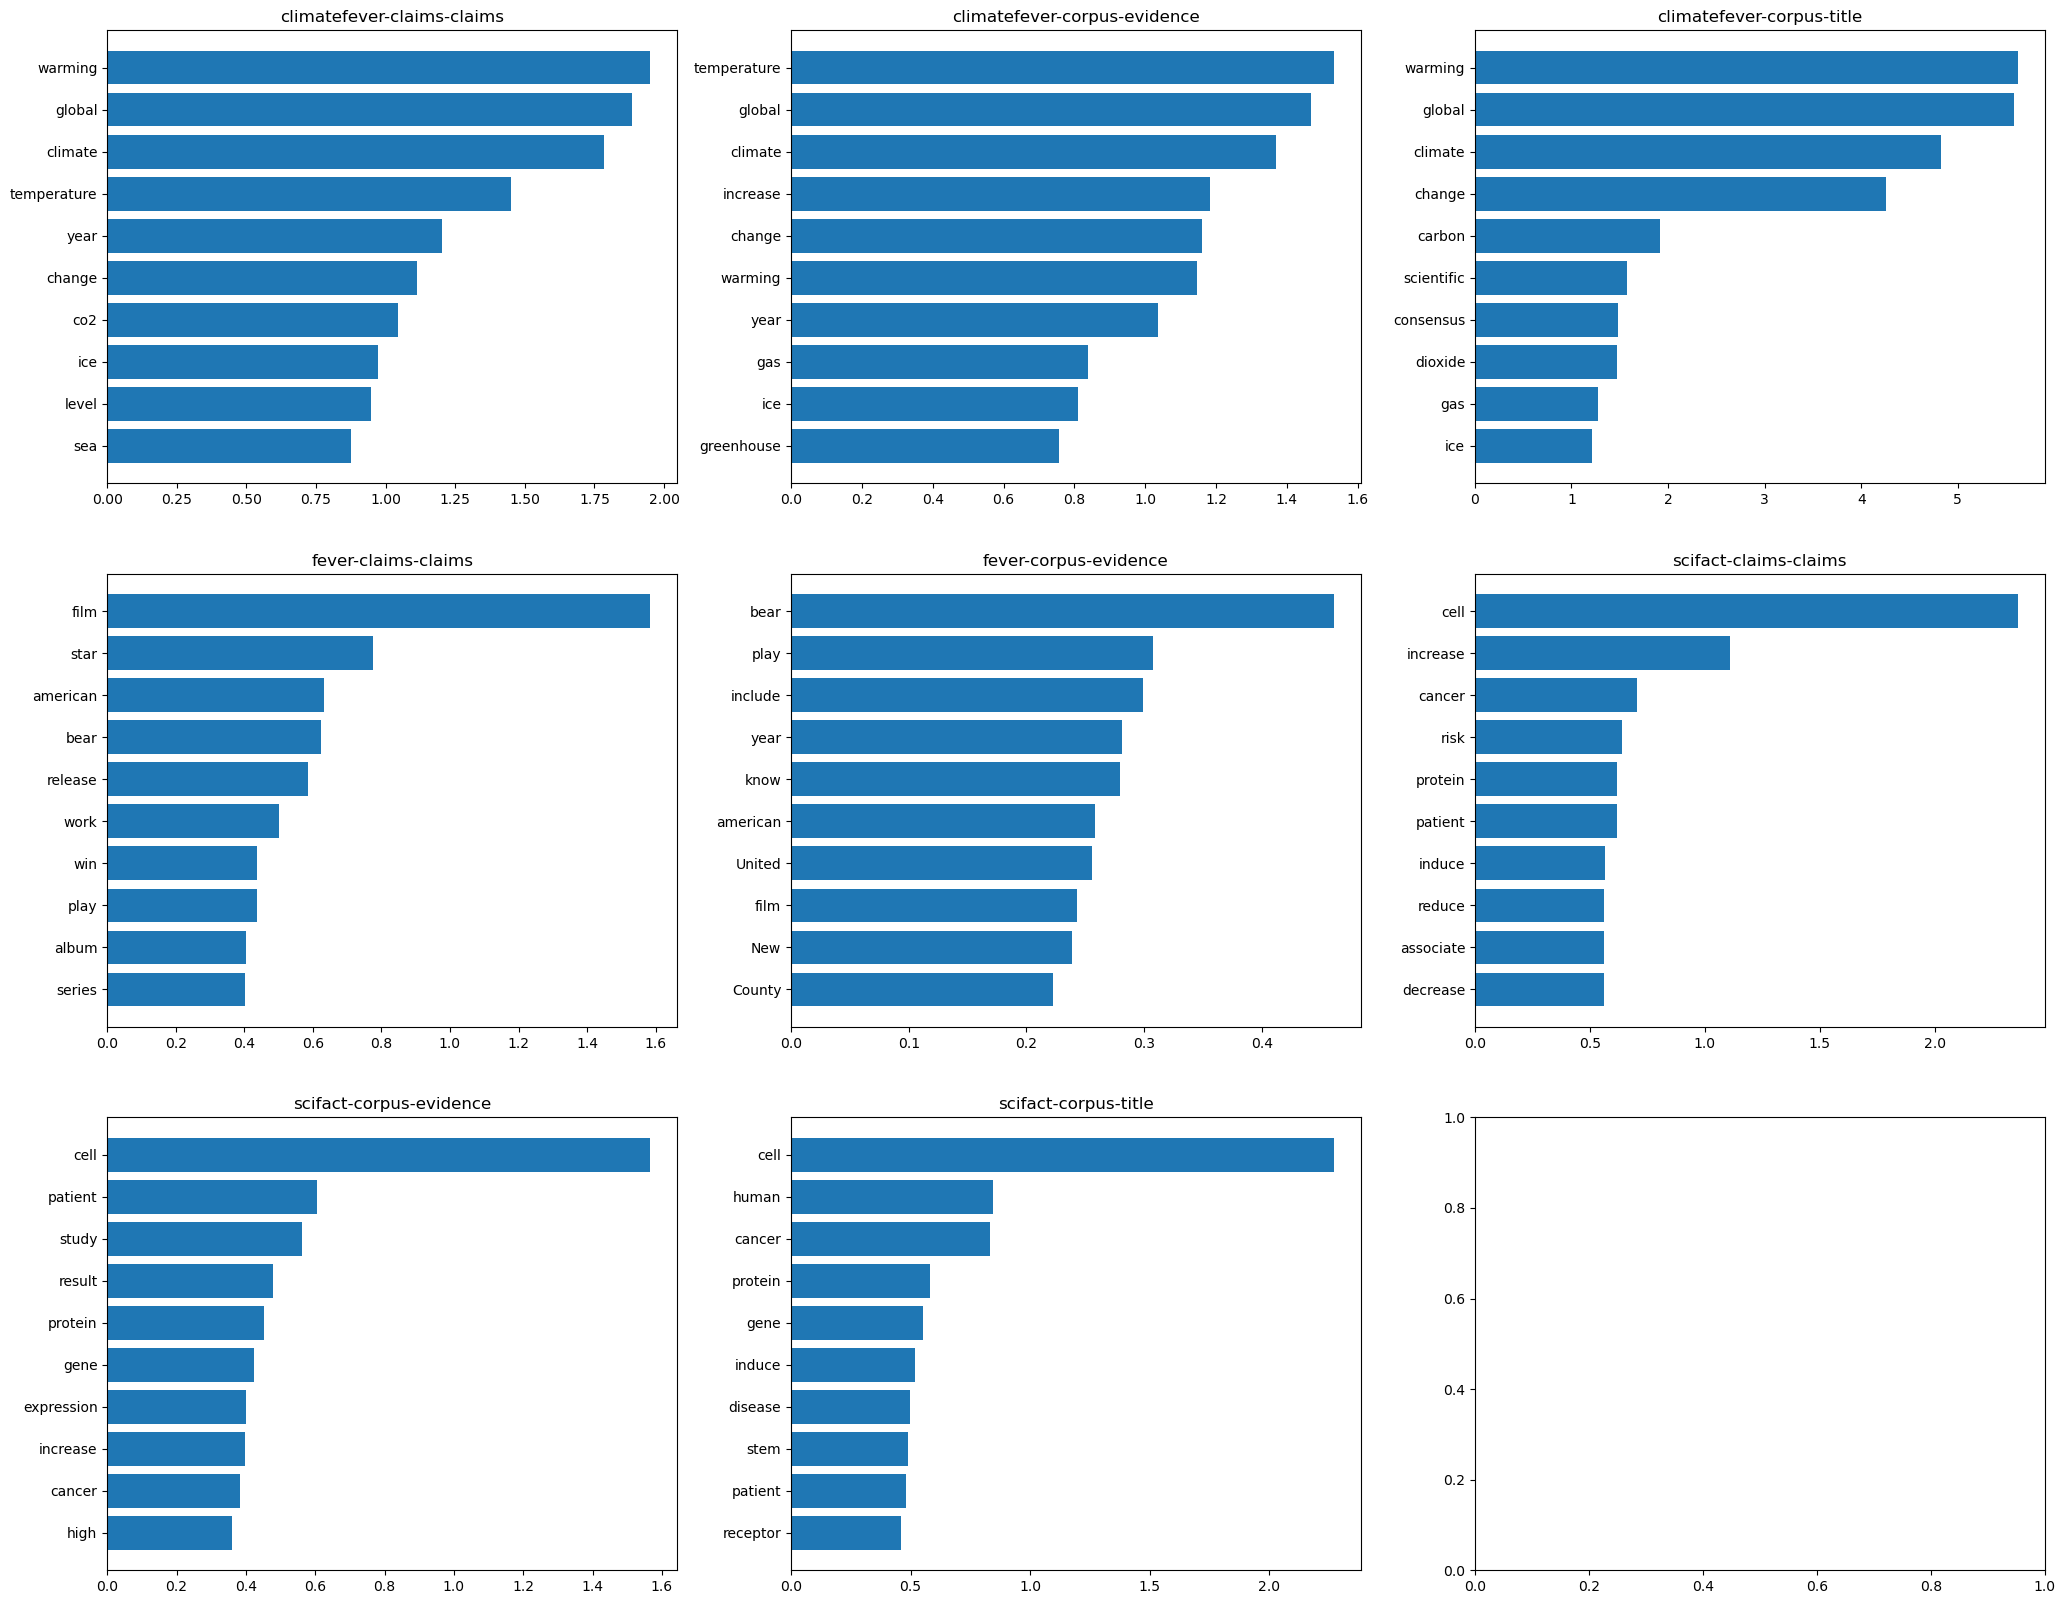

In [10]:
datasets = df_topwords["dataset"].unique()
cols = 3
rows = int(np.ceil(len(datasets)/cols))
fig, ax = plt.subplots(rows, cols, figsize=[25, 20])

datasets = iter(datasets)
term = False
for r in range(rows):
    if term:
        break
    for c in range(cols):
        try:
            d = next(datasets)
            df_tmp = df_topwords.loc[df_topwords["dataset"] == d, ["lemma", "normalised_count"]]
            df_tmp = df_tmp.sort_values("normalised_count", ascending=True)
        except StopIteration:
            term = True
            break
        ax[r][c].barh(y=df_tmp["lemma"], width=df_tmp["normalised_count"])
        ax[r][c].set_title(d)